# Assignment 2
The goal of assignment 2 is to build a segmentation network, which uses SLIC Superpixels as input. In essense, it will be a classifier for superpixels. The end product is a system which, when given an image, computes superpixels and classifies each superpixel as one of the 9 classes of MSRC v1. 

From assignment 1, we already know why SLIC works differently from K-means and how to implement SLIC from scratch. 

This assignment is quite oepn-ended, i.e. we can realize the goal by at least two approaches, 
1. Rescaling every superpixels into 224X224 using resize functions. 
2. Borrow the idea of RoI pooling from Faster-RCNN object detector and use the roi_pool method in PyTorch.

Also, you are welcome to solve the assignment by other approaches as well. 

Here, we provide some ideas of the first method, which is reformulating the Superpixels semantic segmentation problem into an easier problem of image classification. There are basically three steps in the training stage. 

1. Dilate and save each superpixel region from SLIC output into image of size 224X224, alongwith the ground truth segments label. 
2. Build a couple of convolution layers to extract the deep features from each Superpixel patch image. Let the last layer be Fully connected layers.
3. Define the segmentation loss as multi-class classification loss and train a convolutional neural network based classifier
4. During inference, we combine the classifier's predicted labels to form the whole input image's Superpixel segmentation results.

In [3]:
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip --qq msrc_objcategimagedatabase_v1.zip

--2020-12-15 19:23:11--  http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.200.168.112, 2600:1408:3000:294::e59, 2600:1408:3000:28b::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.200.168.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44119839 (42M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v1.zip’

msrc_objcategimaged 100%[===================>]  42.08M   187MB/s    in 0.2s    

2020-12-15 19:23:11 (187 MB/s) - ‘msrc_objcategimagedatabase_v1.zip’ saved [44119839/44119839]



In [4]:
#All important functions to plot, same as assignment 1
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm), 
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value  
    
    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot 
    
    Output: None
    Creates a plot    
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    
    plot_image(seg_img,title)
    
    return     

## Step 1: 
First, we dilate each superpixel and save the output superpixel patch from SLIC into 224X224 size image (after rescaling), alongwith the ground truth segments label. 

For the purpose of consistency, we adopt the existing SLIC implenmentation from the scikit-learn machine learning package. You are welcome to compare your own SLIC Superpixels output from assignment 1 with scikit-image SLIC output. But we would be grading the outputs in comparison to the scikit-image superpixel outputs. 

However, before you start to build a deep learning model, it is always advised for you to visualize and get familar with the images/segmentations in the dataset.

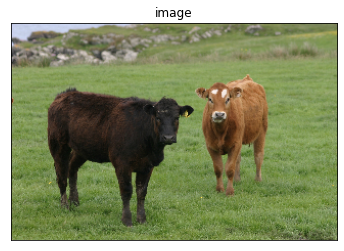

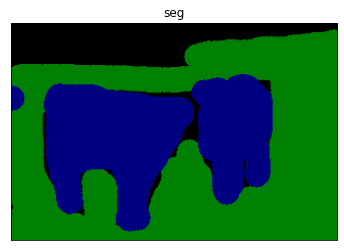

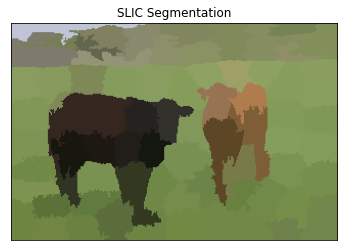

In [5]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')

#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic

segments_sample = slic(image_sample, n_segments=100, compactness=10)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")

In [6]:
import cv2
from skimage.segmentation import slic
from IPython import embed
import os
current_directory = os.getcwd()
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'

In [7]:
#Superpixel dataset preparation

# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": 9, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]}]

# from Dataset_v2
SEG_LABELS_LIST_v2 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

# create a map rgb_2_label, where mapping the ground truth 3-d array segmentation into a single ID label.
rgb_2_label = {}
for i in SEG_LABELS_LIST_v1:
    rgb_2_label[tuple(i['rgb_values'])] = i['id']

Suggested algorithm: Save the superpixels along with their segmentation class

For each image
1. Get superpixels sp_i for image x. We adopt 100 segments in this assignment, 'segments = slic(image, n_segments=100, compactness=10)'.
2. For every superpixel sp_i in the image, \\
    2.1. find the smallest rectangle which can enclose sp_i <br>
    2.2. Dilate the rectangle by 3 pixels.<br>
    2.3. Get the same region from the segmentation image (from the file with similar name with *_GT). The class for this sp_i is mode of segmentation classes in that same region. Save the dilated region as npy (jpg is lossy for such small patches).<br>


Also Suggested would be creating a single csv with columns segment patch location, class label for each sp_i of each image.<br>




In [8]:
# run SLIC on each original images and save the (segment patch, ID label) pair
# segments = slic(image, n_segments=100, compactness=10) 
# it may take up to half an hour to process, depending on the hardware resources
# save the output file names to train.txt 
# Alternatively, you don't save the segment patch and ID label offline, instead, 
# you process them on the fly later.
import csv 
from sklearn.model_selection import train_test_split

 

#os.removedirs('./datasets/')

if not os.path.exists('./datasets/'):
    os.makedirs('./datasets/')

csvfile= open('./datasets/train.csv', 'w')  
csvwriter = csv.writer(csvfile)
csvwriter.writerow(['Location', 'Label'])

csvfile_test= open('./datasets/test.csv', 'w')  
csvwriter_test = csv.writer(csvfile_test)
csvwriter_test.writerow(['Location', 'Label'])

#if os.path.exists('./datasets/files'):
    #os.removedirs('./datasets/files')

if not os.path.exists('./datasets/files'):
    os.makedirs('./datasets/files')

if os.path.exists('./datasets/train.txt'):
    os.remove('./datasets/train.txt')

fil=open('./datasets/train.txt', 'w')
fil2=open('./datasets/test.txt', 'w')
#doing 80:20 split of MSRC dataset
list_allImage=[]
for filename in os.listdir(msrc_directory):
    # Your code 
    #print(filename)
    
    if 'GT' not in filename and '.bmp' in filename:
        list_allImage.append(filename)
#print(list_allImage)
train_list,test_list=train_test_split(list_allImage,test_size=0.2,shuffle=True,random_state=76)
print(len(test_list))
with open('./datasets/train_img.txt', 'w') as f:
    for item in train_list:
        f.write("%s\n" % item)
f.close()
with open('./datasets/test_img.txt', 'w') as f:
    for item in test_list:
        f.write("%s\n" % item)
f.close()
count=0
c1=0
#dataset_path="./datasets/"
for filename in os.listdir(msrc_directory):
    # Your code 
    #print(filename)
    if 'GT' not in filename and '.bmp' in filename:
      c1+=1
      #print(filename)
      image=cv2.imread(os.path.join(msrc_directory,filename))
      image=image[:, :, ::-1]
      image_gt=cv2.imread(os.path.join(msrc_directory,filename[:-4]+'_GT'+'.bmp'))
      image_gt=image_gt[:, :, ::-1]
      #print (image[0][0])
      #if np.array_equal( image[0][0],np.array([252, 247, 248])):
        #print ("haha")
      segments = slic(image, n_segments=100, compactness=10)
      clust = np.unique(segments)
      train_check=False
      
      if filename in train_list:
        train_check=True
      #print(clust)
      for n in clust:
        #print(min,max)
        minRC=np.min(np.argwhere(segments==n),axis=0)
        maxRC=np.max(np.argwhere(segments==n),axis=0)

        #dilation
        for x in minRC:
          if x>2:
            x-=3
        for x in maxRC:
          if x<image.shape[1]-3:
            x+=3

        partImage= image[minRC[0]:maxRC[0]+1,minRC[1]:maxRC[1]+1]
        
        
        #dsize = (224, 224)
        #partImage=cv2.resize(partImage,dsize)
        partImage_name='./datasets/files/'+filename[:-4]+'_' + str(n) 
        #partImage=partImage

        #print(partImage)
        np.save( partImage_name, np.array(partImage))
        PatchFullname=filename[:-4]+'_' + str(n)+ str('.npy')

        if train_check:
          fil.write("%s\n" % PatchFullname)
        else:
          fil2.write("%s\n" % PatchFullname)
        #for x in range(minRC[0],maxRC[0]+1):
          #for y in range(minRC[1],maxRC[1]+1):
          
        imgGtPatch=image_gt[minRC[0]:maxRC[0]+1,minRC[1]:maxRC[1]+1] 
        #print(imgGtPatch)
        #imgGtPatch=imgGtPatch[::-1]
        #print(imgGtPatch[0][0])
        #print("end")
        freq_list=[]
        listRGB=list(rgb_2_label)

        for i in listRGB:   
          freq_list.append(len(np.argwhere(imgGtPatch== i)))
        #print (freq_list)
        Label=rgb_2_label[listRGB[np.argmax(freq_list)]]
        if train_check:
          csvwriter.writerow([partImage_name+'.npy',Label])
        else:
          csvwriter_test.writerow([partImage_name+'.npy',Label])
csvfile.close()
csvfile_test.close()
   

48


Next, we define the dataset and dataloader (depends on how you define the saved rectangular patches!)

This is a dataset 

In [9]:
import os
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
from torch.optim import lr_scheduler
import _pickle as pickle
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import pandas as pd
import copy
# -------------
# Dataset class
# -------------
#
# ``torch.utils.data.Dataset`` is an abstract class representing a
# dataset.
# Your custom dataset should inherit ``Dataset`` and override the following
# methods:
#
# -  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
# -  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
#    be used to get sp_i sample
#
# Let's create a dataset class for our superpixel dataset. We will
# read the csv in ``__init__`` but leave the reading of images to
# ``__getitem__``. This is memory efficient because all the images are not
# stored in the memory at once but read as required.
#
# Sample of our dataset will be a dict
# ``{'superpixel image': image, 'superpixel class': class}``. Our dataset will take an
# optional argument ``transform`` so that any required processing can be
# applied on the sample. Remember to resize the image using ``transform``.

class SegmentationData(data.Dataset):

    def __init__(self, csv_file, transform=None):
        # Your code 
        self.superpixel = pd.read_csv(csv_file)
        #self.root_dir = root_dir
        self.transform = transform
            
    def __len__(self):
        # Your code 
        return len(self.superpixel)

    
    def __getitem__(self, index):
        # Your code 
        sample = {'superpixel image': Image.fromarray(np.load(self.superpixel.iloc[index,0])), 'superpixel class': self.superpixel.iloc[index,1]}
        #print(sample['superpixel image'].array())
        if self.transform:
            sample['superpixel image'] = self.transform(sample['superpixel image'])

        return sample['superpixel image'],sample['superpixel class']





## Step 2:  Now that you have dataset ready, we start to build the deep network

We use a pre-trained network (like VGG) and replace the last few layers with a fully connected layer.

In [10]:
# Model definition
class SegmentationNN(nn.Module):
    def __init__(self):
        # Your code 
        super(SegmentationNN, self).__init__()
        self.model_res = models.resnet50(pretrained=True)
      
        for param in self.model_res.parameters():
            param.requires_grad = False
        num_ftrs = self.model_res.fc.in_features
        self.model_res.fc = nn.Linear(num_ftrs, 10)
        #self.fcparameters=self.model_res.fc.parameters()
        #self.model_Vgg = self.model_Vgg.to(device)
        #return self.model_vgg
    def forward(self,input):
        # Your code 
        return self.model_res(input)


## Step 3: 

Finally, we define the classification loss and optimizer such that we can learn a superpixel classifier from the backproporgation algorithm. 

In [57]:
# Optimizer
import torch.optim as optim 
class Solver(object):
    def __init__(self,model):
        # Your code 
        self.criterion=nn.CrossEntropyLoss()
        self.optimizer=optim.Adam(model.model_res.fc.parameters(), lr=0.001)
        self.exp_lr_scheduler = lr_scheduler.StepLR(self.optimizer, step_size=7, gamma=0.1)
    def train(self,model,epoch_num):
        # Your code 
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        for epoch in range(epoch_num):  # loop over the dataset multiple times
            print('Epoch {}/{}'.format(epoch, epoch_num - 1))
            #model.train(True)
            
            for phase in ['train']:
              if phase == 'train':
                  model.train(True)  # Set model to training mode
              else:
                  model.train(False)
              running_loss = 0.0
              running_corrects = 0
              for inputs, labels in dataloader[phase]:
                  # get the inputs; data is a list of [inputs, labels]
                  #print(inputs)
                  #print(labels)
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  # zero the parameter gradients
                  self.optimizer.zero_grad()

                  # forward + backward + optimize
                  with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = self.criterion(outputs, labels)
                    #print(outputs)
                    #print(labels)
                    if phase == 'train':                                
                      loss.backward()
                      self.optimizer.step()
                  
                  # print statistics
                  running_loss += loss.item() * inputs.size(0)
                  #print(labels.data)
                  running_corrects += torch.sum(preds == labels.data)

              if phase == 'train':      
                self.exp_lr_scheduler.step()
              #print(dataset_sizes[phase])
              epoch_loss = running_loss / dataset_sizes[phase]
              epoch_acc = running_corrects.double() / dataset_sizes[phase]

              if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

              print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        print('Final Train Acc: {:4f}'.format(epoch_acc))
        print('Finished Training')


    def test(self,model):
        # Your code 
        #best_model_wts = copy.deepcopy(model.state_dict())
        #best_acc = 0.0
        
        #model.train(True)
        pred_list=[]
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloader['test']:
            # get the inputs; data is a list of [inputs, labels]
            #print(inputs)
            #print(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            self.optimizer.zero_grad()

            # forward + backward + optimize
            
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = self.criterion(outputs, labels)
            #print(outputs)
            #print(labels)
              
            
            # print statistics
            running_loss += loss.item() * inputs.size(0)
            #print(labels.data)
            running_corrects += torch.sum(preds == labels.data)
            pred_list+=(preds.data.cpu().numpy().tolist())
        
          #print(dataset_sizes[phase])
        epoch_loss = running_loss / dataset_sizes['test']
        epoch_acc = running_corrects.double() / dataset_sizes['test']

        #print("here")
        #print(len(pred_list))
        #print(pred_list)
        np.savetxt('./datasets/output.csv', pred_list,delimiter=' ',header="predicted")
        print('Test Loss: {:.4f} Test Acc: {:.4f}'.format( epoch_loss, epoch_acc))
        
        #print('Best val Acc: {:4f}'.format(best_acc))    

## Putting it together:
Start to train your network and observe the loss in time.
During the inference stage, we combine the SLIC Superpixels' predicted labels to form the whole input image's Superpixel segmentation results.

In [58]:

# load the data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        #transforms.RandomHorizontalFlip(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_data = {x:SegmentationData(csv_file='./datasets/'+x+'.csv',transform=data_transforms[x])  for x in ['train', 'test']}
# data loader
dataloader = {'train': torch.utils.data.DataLoader(train_data['train'], batch_size=128, shuffle=True, num_workers=0),
              'test':torch.utils.data.DataLoader(train_data['test'], batch_size=128, shuffle=False, num_workers=0)}
dataset_sizes =  {x: len(train_data[x]) for x in ['train', 'test']} 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)
# model
model=SegmentationNN()
model=model.to(device)

# train the model
solver=Solver(model)
solver.train(model,100)
solver.test(model)

Epoch 0/99
train Loss: 1.0515 Acc: 0.6496
Epoch 1/99
train Loss: 0.6750 Acc: 0.7618
Epoch 2/99
train Loss: 0.6127 Acc: 0.7846
Epoch 3/99
train Loss: 0.5777 Acc: 0.7937
Epoch 4/99
train Loss: 0.5516 Acc: 0.8002
Epoch 5/99
train Loss: 0.5227 Acc: 0.8072
Epoch 6/99
train Loss: 0.5107 Acc: 0.8180
Epoch 7/99
train Loss: 0.4722 Acc: 0.8306
Epoch 8/99
train Loss: 0.4698 Acc: 0.8302
Epoch 9/99
train Loss: 0.4746 Acc: 0.8315
Epoch 10/99
train Loss: 0.4688 Acc: 0.8316
Epoch 11/99
train Loss: 0.4672 Acc: 0.8343
Epoch 12/99
train Loss: 0.4703 Acc: 0.8310
Epoch 13/99
train Loss: 0.4644 Acc: 0.8353
Epoch 14/99
train Loss: 0.4675 Acc: 0.8318
Epoch 15/99
train Loss: 0.4646 Acc: 0.8326
Epoch 16/99
train Loss: 0.4634 Acc: 0.8315
Epoch 17/99
train Loss: 0.4597 Acc: 0.8368
Epoch 18/99
train Loss: 0.4637 Acc: 0.8339
Epoch 19/99
train Loss: 0.4666 Acc: 0.8310
Epoch 20/99
train Loss: 0.4601 Acc: 0.8361
Epoch 21/99
train Loss: 0.4604 Acc: 0.8341
Epoch 22/99
train Loss: 0.4627 Acc: 0.8338
Epoch 23/99
train Los

71


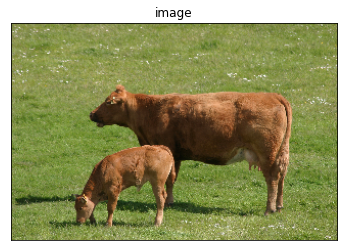

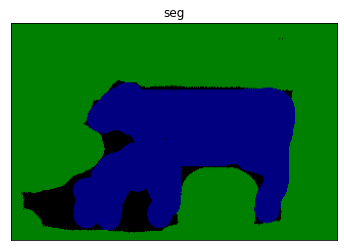

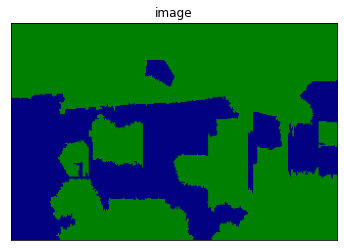

In [61]:
#Visualization


#  plot a sample image and its ground truth segments
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_9_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_9_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')
preds=np.genfromtxt("./datasets/output.csv")
label_2_rgb = {}
for i in SEG_LABELS_LIST_v1:
    label_2_rgb[i['id']] = i['rgb_values']
#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic
preds=preds[0:71] #for MSRC_ObjCategImageDatabase_v1/1_9_s.bmp please check test.csv and output.csv
#print(len(preds))
image_sample=image_sample[:,:,::-1]
segments_sample = slic(image_sample, n_segments=100, compactness=10)
clust=np.unique(segments_sample)
#print(len(clust))
for n in clust:
  #print(n)
  image_sample[segments==n]=label_2_rgb[preds[n]]
image_sample=image_sample[:,:,::-1]
plot_image(image_sample, 'image')

## Bonus Qs:
We always want to increase the classifier accuracy and achieve a better performance by building a complicated deep learning model. There are a lot of tricks which are very popular and work in practice. Try to implement either of following two,

1. Could you effictively fuse different deep features from multiple layers in your network? You are welcome to use the pretrained network. Does your network achieve a better accuracy? There are a lot of exploration in the literature, including ION (Inside-Outside Net) [1], Hypercolumns [2], and PixelNet [3]. The following figure illustrates ION architecture combining features from different layers. Can you do similar thing for our Superpixel classifier?

In [ ]:
#TODO




In [ ]:
from IPython.display import Image
Image(filename='/ION.png') 


2. Could you build a Multi-resolution network to explore the effectiveness of the multi-scale on the task of Superpixels segmentation? By multi-scale, we mean multiple resolutions of superpixels. See [4] and the following illustration figure for an example.

In [63]:
#TODO
Multi resolution
# run SLIC on each original images and save the (segment patch, ID label) pair
# segments = slic(image, n_segments=80, 100, 120 compactness=10) 
# it may take up to half an hour to process, depending on the hardware resources
# save the output file names to train.txt 
# Alternatively, you don't save the segment patch and ID label offline, instead, 
# you process them on the fly later.
import csv 
from sklearn.model_selection import train_test_split

 

#os.removedirs('./datasets/')

if not os.path.exists('./datasets/MultiRes/'):
    os.makedirs('./datasets/MultiRes/')

csvfile= open('./datasets/MultiRes/train.csv', 'w')  
csvwriter = csv.writer(csvfile)
csvwriter.writerow(['Location', 'Label'])

csvfile_test= open('./datasets/MultiRes/test.csv', 'w')  
csvwriter_test = csv.writer(csvfile_test)
csvwriter_test.writerow(['Location', 'Label'])

#if os.path.exists('./datasets/files'):
    #os.removedirs('./datasets/files')

if not os.path.exists('./datasets/MultiRes/files'):
    os.makedirs('./datasets/MultiRes/files')

if os.path.exists('./datasets/MultiRes/train.txt'):
    os.remove('./datasets/MultiRes/train.txt')

fil=open('./datasets/MultiRes/train.txt', 'w')
fil2=open('./datasets/MultiRes/test.txt', 'w')
#doing 80:20 split of MSRC dataset
list_allImage=[]
for filename in os.listdir(msrc_directory):
    # Your code 
    #print(filename)
    
    if 'GT' not in filename and '.bmp' in filename:
        list_allImage.append(filename)
#print(list_allImage)
train_list,test_list=train_test_split(list_allImage,test_size=0.2,shuffle=True,random_state=76)
print(len(test_list))
with open('./datasets/MultiRes/train_img.txt', 'w') as f:
    for item in train_list:
        f.write("%s\n" % item)
f.close()
with open('./datasets/MultiRes/test_img.txt', 'w') as f:
    for item in test_list:
        f.write("%s\n" % item)
f.close()
count=0
c1=0
#dataset_path="./datasets/"
for filename in os.listdir(msrc_directory):
    # Your code 
    #print(filename)
    if 'GT' not in filename and '.bmp' in filename:
      c1+=1
      #print(filename)
      image=cv2.imread(os.path.join(msrc_directory,filename))
      image=image[:, :, ::-1]
      image_gt=cv2.imread(os.path.join(msrc_directory,filename[:-4]+'_GT'+'.bmp'))
      image_gt=image_gt[:, :, ::-1]
      #print (image[0][0])
      #if np.array_equal( image[0][0],np.array([252, 247, 248])):
        #print ("haha")
      
      train_check=False
      
      if filename in train_list:
        train_check=True
      #print(clust)
      for n_seg in [80, 100, 120]:
        segments = slic(image, n_segments=n_seg, compactness=10)
        clust = np.unique(segments)

        if n_seg==80:
          clustLen1=len(clust)
        elif n_seg==100:
          clustLen2=len(clust) 
        else:
          clustlen3=len(clust)

        for n in clust:
          #print(min,max)
          minRC=np.min(np.argwhere(segments==n),axis=0)
          maxRC=np.max(np.argwhere(segments==n),axis=0)

          #dilation
          for x in minRC:
            if x>2:
              x-=3
          for x in maxRC:
            if x<image.shape[1]-3:
              x+=3

          partImage= image[minRC[0]:maxRC[0]+1,minRC[1]:maxRC[1]+1]
          
          
          #dsize = (224, 224)
          #partImage=cv2.resize(partImage,dsize)
          if n_seg==80:
            partImage_name='./datasets/MultiRes/files/'+filename[:-4]+'_' + str(n) 
          elif n_seg==100:
            partImage_name='./datasets/MultiRes/files/'+filename[:-4]+'_' + str(n+clustLen1)
          else:
            partImage_name='./datasets/MultiRes/files/'+filename[:-4]+'_' + str(n+clustLen1+clustLen2)
          #partImage=partImage

          #print(partImage)
          np.save( partImage_name, np.array(partImage))

          if n_seg==80:
            PatchFullname=filename[:-4]+'_' + str(n)+ str('.npy')
          elif n_seg==100:
            PatchFullname=filename[:-4]+'_' + str(n+clustLen1)+ str('.npy')
          else:
            PatchFullname=filename[:-4]+'_' + str(n+clustLen1+clustLen2)+ str('.npy')
          

          if train_check:
            fil.write("%s\n" % PatchFullname)
          else:
            fil2.write("%s\n" % PatchFullname)
          #for x in range(minRC[0],maxRC[0]+1):
            #for y in range(minRC[1],maxRC[1]+1):
            
          imgGtPatch=image_gt[minRC[0]:maxRC[0]+1,minRC[1]:maxRC[1]+1] 
          #print(imgGtPatch)
          #imgGtPatch=imgGtPatch[::-1]
          #print(imgGtPatch[0][0])
          #print("end")
          freq_list=[]
          listRGB=list(rgb_2_label)

          for i in listRGB:   
            freq_list.append(len(np.argwhere(imgGtPatch== i)))
          #print (freq_list)
          Label=rgb_2_label[listRGB[np.argmax(freq_list)]]
          if train_check:
            csvwriter.writerow([partImage_name+'.npy',Label])
          else:
            csvwriter_test.writerow([partImage_name+'.npy',Label])
csvfile.close()
csvfile_test.close()




48


In [66]:
# load the data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        #transforms.RandomHorizontalFlip(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_data = {x:SegmentationData(csv_file='./datasets/MultiRes/'+x+'.csv',transform=data_transforms[x])  for x in ['train', 'test']}
# data loader
dataloader = {'train': torch.utils.data.DataLoader(train_data['train'], batch_size=128, shuffle=True, num_workers=0),
              'test':torch.utils.data.DataLoader(train_data['test'], batch_size=128, shuffle=False, num_workers=0)}
dataset_sizes =  {x: len(train_data[x]) for x in ['train', 'test']} 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)
# model
#model=SegmentationNN()
#model=model.to(device)

# train the model
#solver=Solver(model)
solver.train(model,10)
solver.test(model)

Epoch 0/9
train Loss: 0.4998 Acc: 0.8195
Epoch 1/9
train Loss: 0.5004 Acc: 0.8191
Epoch 2/9
train Loss: 0.5005 Acc: 0.8204
Epoch 3/9
train Loss: 0.4995 Acc: 0.8201
Epoch 4/9
train Loss: 0.5016 Acc: 0.8196
Epoch 5/9
train Loss: 0.5003 Acc: 0.8211
Epoch 6/9
train Loss: 0.5005 Acc: 0.8204
Epoch 7/9
train Loss: 0.4998 Acc: 0.8209
Epoch 8/9
train Loss: 0.5000 Acc: 0.8194
Epoch 9/9
train Loss: 0.4994 Acc: 0.8209
Final Train Acc: 0.820910
Finished Training
Test Loss: 0.5630 Test Acc: 0.7973


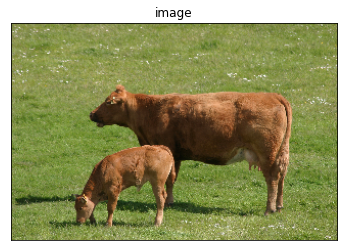

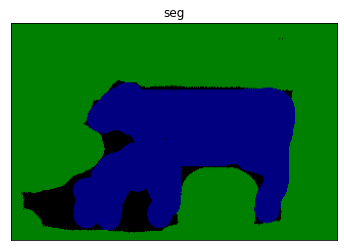

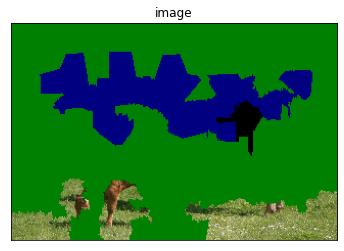

In [69]:
#Visualization


#  plot a sample image and its ground truth segments
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_9_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_9_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')
preds=np.genfromtxt("./datasets/output.csv")
label_2_rgb = {}
for i in SEG_LABELS_LIST_v1:
    label_2_rgb[i['id']] = i['rgb_values']
#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic
preds=preds[0:71] #for MSRC_ObjCategImageDatabase_v1/1_9_s.bmp please check test.csv and output.csv
#print(len(preds))
image_sample=image_sample[:,:,::-1]
segments_sample = slic(image_sample, n_segments=100, compactness=10)
clust=np.unique(segments_sample)
#print(len(clust))
for n in clust:
  #print(n)
  image_sample[segments==n]=label_2_rgb[preds[n]]
image_sample=image_sample[:,:,::-1]
plot_image(image_sample, 'image') 

[1] Inside-Outside Net: Detecting Objects in Context with Skip Pooling and Recurrent Neural Networks

[2] Hypercolumns for Object Segmentation and Fine-grained Localization

[3] PixelNet: Representationofthe pixels, by the pixels, and for the pixels

[4] Feedforward semantic segmentation with zoom-out features